In the previous post, I used the MOMA collection dataset to demonstrate some features of pandas, a python library that makes SQL-like operations relatively easy.

In this post I'm going to apply another python library to this dataset. [sexmachine](https://github.com/ferhatelmas/sexmachine/) is a python library that determines the gender of a name. It requires Python 2.

Despite its charming name, sexmachine does not infer sex (it infers gender) and it doesn't use machine learning (it's a table of names.) But despite its limitations, we can use it to look at gross trends in the evolving gender ratio of the MOMA collection.

Determining gender from a name is a difficult thing to do accurately for many reasons, among them:
 
 - there are more than two genders
 - names can be used by more than one gender
 - this can vary systematically with time or location
 - sexmachine (and the alternatives) have coverage that varies with language

This is not a complete list of the problems with this approach, and sexmachine is not necessarily the best way of handling them. J. Nathan Mathias at MIT wrote [a great post on this](https://civic.mit.edu/blog/natematias/best-practices-for-ethical-gender-research-at-very-large-scales).

That said, provided we are willing to make the reasonable assumption that sexmachine screws up equally often for men and women, and consider only ratios we can make statements about *trends* in the gender split of the MOMA collection.

First let's recreate the environment from the previous post.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('poster')
moma = pd.read_csv('Artworks.csv', index_col=12, parse_dates=[10])
moma = moma.dropna(subset=['DateAcquired'])
firsts = moma.drop_duplicates('Artist')

Then we define a helper function that takes a full name as a string and returns sexmachine's best guess for the gender of the first word in that string (which is assumed to be the first name)

In [2]:
import sexmachine.detector as detector  # requires python2
g = detector.Detector()

def infer_gender(fullname):
    try:
        return g.get_gender(fullname.split()[0])
    except:
        return

Now we apply the `infer_gender` function to the `Artists` field in the dataset of unique artists, and take a look at the distributions of inferred gender.

In [7]:
firsts['Gender'] = firsts['Artist'].apply(infer_gender)
firsts.groupby('Gender')['Gender'].count()

/Users/mike/.virtualenvs/ds/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Gender
andy             2661
female           1663
male             8056
mostly_female     189
mostly_male       264
Name: Gender, dtype: int64

As expected, its mostly male. But more improtantly, we see a couple of the problems with sexmachine. Names it cannot guess are called `andy` (for androgynous?!). Names that it is not confident are `mostly_male` or `mostly_female`. Among the 12921 artists in the collection, nearly a quarter have first names whose gender sexmachine is unable to guess.

Depite this: we're now in a position to examine the how many artists in the MOMA collection who have first names that are usually female, as a fraction of the number of artists whose gender sexmachine determined with confidence.

This is not exactly what we're interested in, but it should at least be *directionally* correct (when this number goes up, the fraction of new artists added to the collection who really do identify as female has gone up).

And if, as discussed above, we're willing to assuming that sexmachine fails to correctly determine the gender of women as often as men, it should be more than just directionally correct; it should be pretty close to the right answer.

We create a new DataFrame to record the number of people in each gender newly added to the collection in five year buckets. We do this by grouping by two of the fields (`DateAcquired` and `Gender`). This yields a Series with a hierarchical index, which we turn into a regular DataFrame using the `unstack()` method.

In [8]:
gender_trends = (firsts
                 .groupby([pd.Grouper(key='DateAcquired', freq='5A'), 'Gender'])['DateAcquired']
                 .count()
                 .unstack())

gender_trends['percent female'] = 100. * gender_trends['female'] / (gender_trends['male'] + gender_trends['female'])

/Users/mike/.virtualenvs/ds/lib/python2.7/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


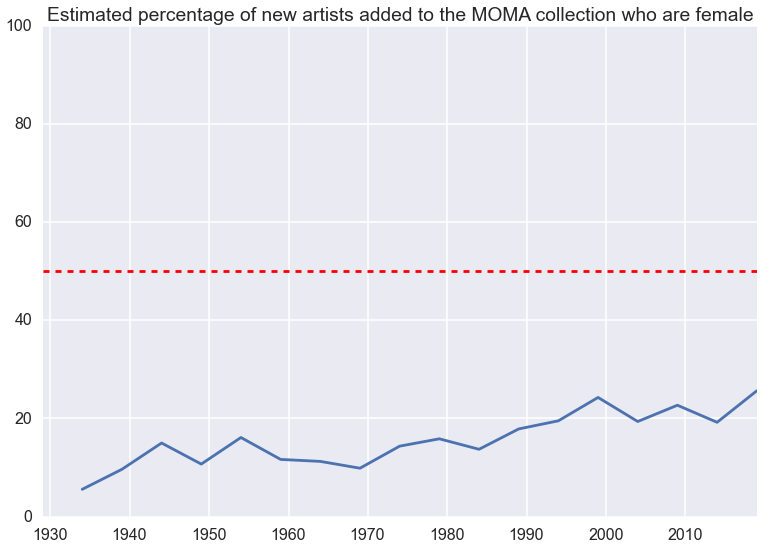

In [10]:
fig, ax = plt.subplots()
gender_trends['percent female'].plot()
ax.set_title('Estimated percentage of new artists added to the MOMA collection who are female')
ax.set_xlabel('')
ax.plot(ax.get_xlim(), [50, 50], 'r--')
ax.set_ylim(0, 100);

Assuming you think it's desirable that the MOMA collection represents female artists, there's bad news and good news from this plot:

 - the bad news: around 20% of artists added to the collection each year are female (for those of you keeping score, this is less than 50%)
 - the good news: this number is rising (around 10% in 1940 to approaching 25% today)

Seaborn has a nice function to generate a regression plot (i.e. fit a trendline to this data) with uncertainties, which we can use to see what lies in the future if this trend continues at the present rate.

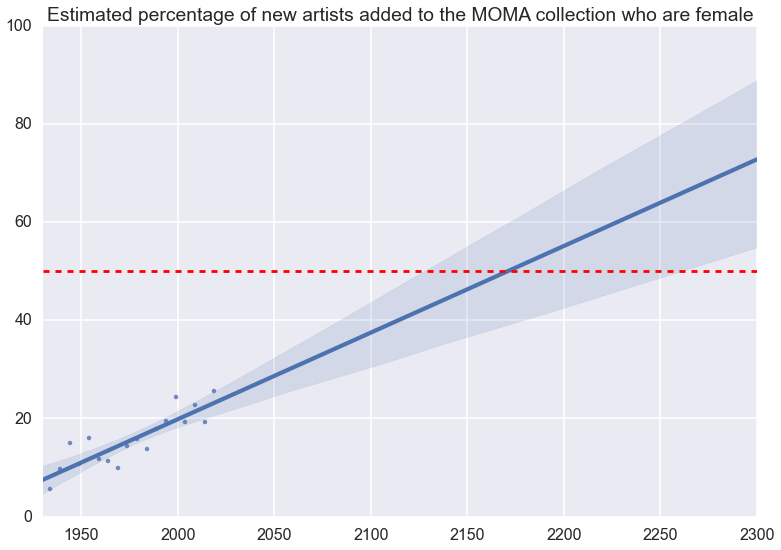

In [13]:
fig, ax = plt.subplots()
ax.set_ylim(0, 100);
ax.set_xlim(1930, 2300);
sns.regplot(x=gender_trends.reset_index()['DateAcquired'].apply(lambda x: x.year),
            y=gender_trends["percent female"])
ax.set_title('Estimated percentage of new artists added to the MOMA collection who are female')
ax.set_xlabel('')
ax.set_ylabel('')
ax.plot(ax.get_xlim(), [50, 50], 'r--');

So, at the present rate, half the new artists MOMA acquires will be female by the mid 22nd century, just after the institution's 200th anniversay in 2129.